In [1]:
# Import numpy, pandas, matplotlib.pyplot and seaborn
import numpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.plotting import plot_decision_regions

sns.set_style('darkgrid')
%matplotlib inline

In [2]:
sba = pd.read_csv('../data/SBA_cleaned_data.csv')
df = sba.copy()

df = df[df.ApprovalFY >= 2000]

In [3]:
features = ['NAICS', 'ApprovalFY', 'Term', 'NewExist','HasFranchise','UrbanRural','RevLineCr', 'GrAppv']

x = df.loc[:, features]
y = df.loc[:,['Default']]

In [4]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(x,y,random_state=0)

In [5]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_train = pd.DataFrame(ss.fit_transform(X_train),columns=X_train.columns)

X_test = ss.transform(X_test)

In [6]:
X_train.columns.values

array(['NAICS', 'ApprovalFY', 'Term', 'NewExist', 'HasFranchise',
       'UrbanRural', 'RevLineCr', 'GrAppv'], dtype=object)

In [7]:
X_train.agg(['mean','std']).T

,mean,std
NAICS,-1.178414e-16,1.000001
ApprovalFY,1.663585e-14,1.000001
Term,-6.614762e-17,1.000001
NewExist,2.210589e-18,1.000001
HasFranchise,-4.083212e-17,1.000001
UrbanRural,4.758080e-17,1.000001
RevLineCr,1.568668e-17,1.000001
GrAppv,3.857902e-18,1.000001


Feature Selection: LASSO

In [8]:
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression(C = 0.1, penalty="l1", solver="liblinear", random_state=0)
logr.fit(X_train, y_train)

sorted_tuples = sorted(list(zip(X_train.columns.values,logr.coef_[0])),key=lambda x:x[1],reverse=True)
for feature,coef in sorted_tuples:
    print(f'{feature:30s} : {coef: 0.3f}')

C:\Users\hjn19\anaconda3\envs\eods-s22\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


ApprovalFY                     :  0.357
GrAppv                         :  0.140
NAICS                          :  0.106
UrbanRural                     :  0.072
HasFranchise                   :  0.033
NewExist                       :  0.032
RevLineCr                      : -0.095
Term                           : -1.921


In [9]:
sorted_tuples = sorted(list(zip(X_train.columns.values,logr.coef_[0])),key=lambda x:x[1],reverse=True)
for feature,coef in sorted_tuples:
    print(f'{feature:30s} : {coef: 0.3f}')

ApprovalFY                     :  0.357
GrAppv                         :  0.140
NAICS                          :  0.106
UrbanRural                     :  0.072
HasFranchise                   :  0.033
NewExist                       :  0.032
RevLineCr                      : -0.095
Term                           : -1.921


Feature Selection: Tree Based

In [10]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=0).fit(X_train,y_train)
feature_importances = pd.Series(rf.feature_importances_,index=X_train.columns)
feature_importances.sort_values(ascending=False).round(3)

C:\Users\hjn19\AppData\Local\Temp\ipykernel_30524\3134166377.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(random_state=0).fit(X_train,y_train)


Term            0.595
GrAppv          0.155
ApprovalFY      0.136
NAICS           0.063
UrbanRural      0.026
RevLineCr       0.014
NewExist        0.007
HasFranchise    0.003
dtype: float64

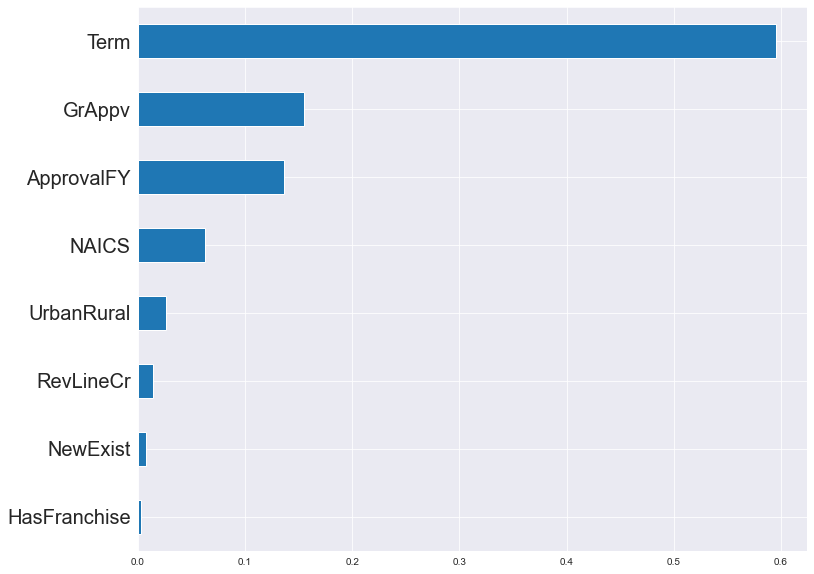

In [11]:
fig,ax = plt.subplots(1,1,figsize=(12,10))
feature_importances.sort_values().plot.barh(ax=ax);
ax.set_yticklabels(ax.get_yticklabels(),fontsize=20);

Feature Selection: Selection From Model

In [12]:
from sklearn.feature_selection import SelectFromModel
sfm_rf = SelectFromModel(RandomForestClassifier(),
                         threshold='mean',   # return all features with value greater than the mean
                         prefit=False        # will refit
                        ).fit(X_train,y_train)

X_train.columns[sfm_rf.get_support()]

sfm_rf = SelectFromModel(RandomForestClassifier(),threshold='mean')
X_train_subset = sfm_rf.fit_transform(X_train,y_train)
X_test_subset = sfm_rf.transform(X_test)

C:\Users\hjn19\anaconda3\envs\eods-s22\lib\site-packages\sklearn\feature_selection\_from_model.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
C:\Users\hjn19\anaconda3\envs\eods-s22\lib\site-packages\sklearn\feature_selection\_from_model.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


In [13]:
feature_importances = pd.Series(sfm_rf.estimator_.feature_importances_,index=X_train.columns)
feature_importances.sort_values(ascending=False).round(3)

Term            0.592
GrAppv          0.156
ApprovalFY      0.139
NAICS           0.063
UrbanRural      0.026
RevLineCr       0.013
NewExist        0.007
HasFranchise    0.003
dtype: float64

In [8]:
from sklearn.decomposition import PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

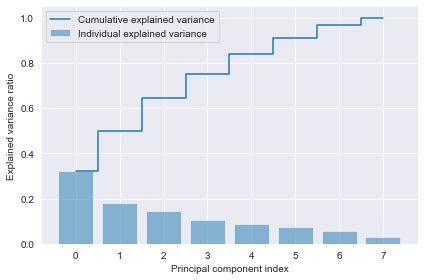

In [9]:
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [10]:
# > 80% of variance
pca = PCA(n_components = 5)
X_train = pca.fit_transform(X_train)
X_train = pd.DataFrame(X_train,columns=["component"+str(i) for i in range(5)])

X_test = pca.transform(X_test)
X_test = pd.DataFrame(X_test,columns=["component"+str(i) for i in range(5)])

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
# Create Decision Tree Model
dt = DecisionTreeClassifier().fit(X_train,y_train)
y_pred = dt.predict(X_test)
print("Accuracy of full data & all features:",metrics.accuracy_score(y_test, y_pred))

Accuracy of full data & all features: 0.8850513335965825


In [14]:
# Improve Model
from sklearn.model_selection import GridSearchCV
params = {
    'max_depth': [5, 10, 20, 50, 100, 150],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}
grid_search = GridSearchCV(DecisionTreeClassifier(), 
                           param_grid=params, 
                           refit=True,
                           cv=5, n_jobs=-1, verbose=1, scoring = "balanced_accuracy").fit(X_train,y_train)
print(f'bt best hyperparams: {grid_search.best_params_}')
print(f'bt best mean cv accuracy: {grid_search.best_score_:.5f}')

Fitting 5 folds for each of 60 candidates, totalling 300 fits
bt best hyperparams: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 5}
bt best mean cv accuracy: 0.78782


In [15]:
# Accuracy & Time
import time
t1 = time.time()
dt_imp = DecisionTreeClassifier(criterion = 'entropy', max_depth = 20, min_samples_leaf = 5).fit(X_train, y_train)
t2 = time.time()
y_pred_imp = dt_imp.predict(X_test)
t3 = time.time()
print("train time: ", t2 - t1)
print("test time: ", t3 - t2)
print("Accuracy: ",metrics.accuracy_score(y_test, y_pred_imp))
print("Balanced Accuracy: ",metrics.balanced_accuracy_score(y_test, y_pred_imp))

train time:  11.647624731063843
test time:  0.05012249946594238
Accuracy:  0.8926885522489859
Balanced Accuracy:  0.7958885057983449


In [22]:
from sklearn.tree import plot_tree
# fig,ax = plt.subplots(1,1,figsize=(24,12))
# plot_tree(dt_imp,ax=ax,fontsize=7,feature_names=X.columns,filled=True);

In [16]:
pca = PCA(n_components = 5)
X_train = pca.fit_transform(X_train)
X_train = pd.DataFrame(X_train,columns=["component"+str(i) for i in range(5)])

X_test = pca.transform(X_test)
X_test = pd.DataFrame(X_test,columns=["component"+str(i) for i in range(5)])


principalDf = pd.DataFrame(pca.fit_transform(x), columns=["component"+str(i) for i in range(5)]) 
finalDf = pd.concat([principalDf, y], axis = 1)
finalDf.rename(columns = {'y':'Default'}, inplace = True)                     

In [17]:
finalDf.to_csv('../data/SBA_pca.csv')